##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/yamnet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

# YAMNet을 사용한 사운드 분류

YAMNet은 훈련된 [AudioSet-YouTube 코퍼스](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv)에서 521개의 오디오 이벤트 [클래스](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv)를 예측하는 딥 넷입니다. 여기에는 [Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) 심도 분리형 컨볼루션 아키텍처가 사용됩니다.

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

2022-12-14 22:00:41.570998: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:00:41.571105: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:00:41.571115: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


TensorFlow 허브에서 모델을 로드합니다.

참고: 문서를 읽으려면 모델의 [URL](https://tfhub.dev/google/yamnet/1)을 따르세요.

In [3]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

레이블 파일은 모델 자산에서 로드되며 `model.class_map_path()`에 있습니다. `class_names` 변수에 이를 로드합니다.

In [4]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

로드된 오디오가 적절한 sample_rate(16K)인지 확인하고 변환하는 메서드를 추가합니다. 그렇지 않으면 모델의 결과에 영향을 미칩니다.

In [5]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

## 사운드 파일 다운로드 및 준비하기

여기에서 wav 파일을 다운로드하여 들을 수 있습니다. 이미 사용 가능한 파일이 있는 경우, colab에 업로드하고 대신 사용하세요.

참고: 예상되는 오디오 파일은 16kHz 샘플링 속도의 모노 wav 파일이어야 합니다.

In [6]:
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  153k  100  153k    0     0  1114k      0 --:--:-- --:--:-- --:--:-- 1114k


In [7]:
!curl -O https://storage.googleapis.com/audioset/miaow_16k.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100  210k  100  210k    0     0  4895k      0 --:--:-- --:--:-- --:--:-- 4895k


In [8]:
# wav_file_name = 'speech_whistling2.wav'
wav_file_name = 'miaow_16k.wav'
sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')
sample_rate, wav_data = ensure_sample_rate(sample_rate, wav_data)

# Show some basic information about the audio.
duration = len(wav_data)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(wav_data)}')

# Listening to the wav file.
Audio(wav_data, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 6.73s
Size of the input: 107698


/tmpfs/tmp/ipykernel_103019/2211628228.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, wav_data = wavfile.read(wav_file_name, 'rb')


`wav_data`는 `[-1.0, 1.0]`의 값으로 정규화되어야 합니다(모델의 [문서](https://tfhub.dev/google/yamnet/1)에 명시되어 있음).

In [9]:
waveform = wav_data / tf.int16.max

## 모델 실행하기

이제 쉬운 부분: 이미 준비된 데이터를 사용하여 모델을 호출하고 점수, 임베딩 및 스펙트로그램을 얻습니다.

점수는 사용할 주요 결과입니다. 스펙트로그램은 나중에 시각화를 수행하는 데 사용합니다.

In [10]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [11]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Animal


## 시각화

YAMNet은 시각화에 사용할 수 있는 몇 가지 추가 정보도 반환합니다. 추론된 파형, 스펙트로그램 및 상위 클래스를 살펴보겠습니다.

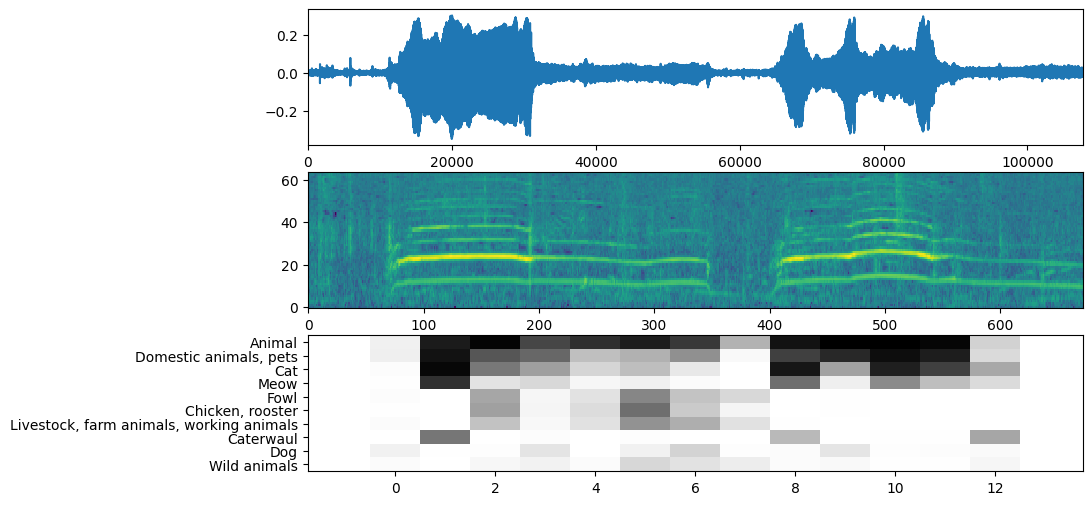

In [12]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))